In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import datetime as dt
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement

station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1dce999cf08>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [10]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1dce99b7c48>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
session.query(measurement.date).order_by(measurement.date.desc()).first()

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

In [12]:
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp).filter(measurement.date > last_year).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data)
precip_df = precip_df.set_index("date")

# Sort the dataframe by date
precip_sort = precip_df.sort_values("date")

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text major ticklabel objects>)

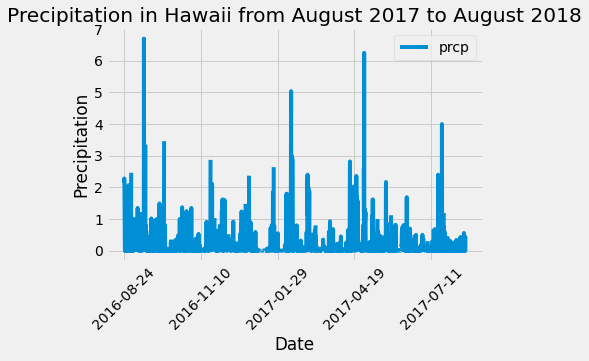

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_sort.plot()
plt.title("Precipitation in Hawaii from August 2017 to August 2018")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.xticks(rotation='45')


In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(station.id).count()
station_count

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
                order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
high_low = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
                        filter(measurement.station == "USC00519281").all()
print(high_low)

[(54.0, 85.0, 71.66378066378067)]


(array([55., 60., 65., 70., 75., 80., 85.]),
 <a list of 7 Text major ticklabel objects>)

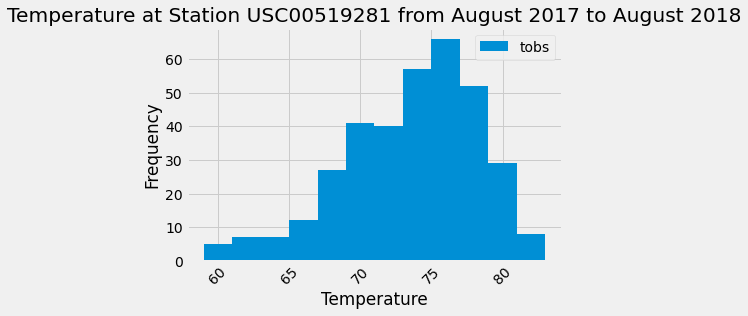

In [19]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.tobs).\
    filter(measurement.date > last_year).\
    filter(measurement.station == 'USC00519281').all()
temp_data

temp_data_df = pd.DataFrame(temp_data)

temp_data_df.plot.hist(bins=12)
plt.title("Temperature at Station USC00519281 from August 2017 to August 2018")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.xticks(rotation='45')


## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vaca_temps = calc_temps('2016-12-23', '2016-12-31')
print(f'Min, Avg, Max Temps = {vaca_temps}')

Min, Avg, Max Temps = [(65.0, 71.71428571428571, 78.0)]


Text(0, 0.5, 'Temperature')

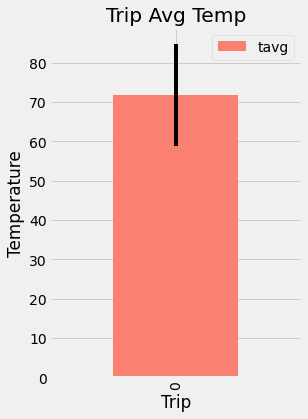

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
vaca_df = pd.DataFrame(vaca_temps, columns=['tmin', 'tavg', 'tmax'])
peak_to_peak = vaca_df['tmax'] - vaca_df['tmin']

vaca_df.plot.bar(y='tavg', yerr=peak_to_peak, color='salmon', figsize=(4,6))
plt.title("Trip Avg Temp")
plt.xlabel("Trip")
plt.ylabel("Temperature")


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-12-23'
end_date = '2016-12-31'

sel = [station.station, station.name, station.latitude, station.longitude, station.elevation,  func.sum(measurement.prcp)]
total_rainfall = session.query(*sel).\
    filter(measurement.station == station.station).\
    filter(measurement.date >= start_date).\
    filter(measurement.date <= end_date).\
    group_by(station.name).order_by( func.sum(measurement.prcp).desc()).all()
total_rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  8.35),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.8800000000000001),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  1.6600000000000001),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.4),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.32),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.23),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = '2016-12-23'
end_date = '2016-12-31'
# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, end_date, freq='D')
# Stip off the year and save a list of %m-%d strings
vaca_dates = date_range.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
for each_date in vaca_dates:
    daily_norms = daily_normals(each_date)
    normals.extend(daily_norms)
    
normals

[(61.0, 70.34693877551021, 78.0),
 (62.0, 70.0625, 78.0),
 (60.0, 71.75, 79.0),
 (63.0, 71.44680851063829, 77.0),
 (62.0, 71.91666666666667, 79.0),
 (62.0, 70.52083333333333, 77.0),
 (57.0, 70.29166666666667, 78.0),
 (63.0, 69.86363636363636, 76.0),
 (56.0, 68.27906976744185, 77.0)]

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
vaca_dates_df = pd.DataFrame(normals, columns=["Min Temp", "Avg Temp", "Max Temp"])
vaca_dates_df["Date"] = vaca_dates
vaca_dates_df = vaca_dates_df.set_index("Date")
vaca_dates_df

,Min Temp,Avg Temp,Max Temp
Date,,,
12-23,61.0,70.346939,78.0
12-24,62.0,70.062500,78.0
12-25,60.0,71.750000,79.0
12-26,63.0,71.446809,77.0
12-27,62.0,71.916667,79.0
12-28,62.0,70.520833,77.0
12-29,57.0,70.291667,78.0
12-30,63.0,69.863636,76.0
12-31,56.0,68.279070,77.0


Text(0, 0.5, 'Temperature')

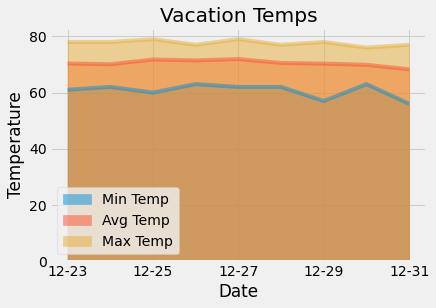

In [58]:
# Plot the daily normals as an area plot with `stacked=False`
vaca_dates_df.plot.area(stacked=False)
plt.title("Vacation Temps")
plt.ylabel("Temperature")